In [1]:
# Eight Queens Problem - optimization by Genetic Algorithms
# Cognizant Data Science Summit - 2020
# Code Implementation by Joyjit Chowdhury

In [2]:
# Import relevant packages
import numpy as np
import random
import sys
from math import ceil
from matplotlib import pyplot as plt

In [3]:
# Class Name :  Board
# Description: An arrangement of Eight Queens in a chessboard. Represents an Inidividual in Genetic Algorithm terminology
# Attributes:  
#      board -  the actual list of queen positions. Each element p(i) is an integer (between 0 and 7 both inclusive)  
#               that implies the row number of the queen in column i of the chessboard.
#      attackingqueens -  the indexes of queens that are attacking some other queen in that board
#      attackcount - number of attacking queens

class Board():
    

    # Default constructor for Board - accepts an arrangement of eight queens as a list of length 8
    # ASSUMPTION: the list would the intergers between 0 and 7 EXACTLY ONCE
    # This is because if any two values match, it will never be a candidate for solution as it means queens are on same row
    def __init__(self, positions): 
        try:
            assert isinstance(positions, list) and len(positions) == 8, 'Board could not be initialized with input'
            self.board = positions
            self.getattackingqueens()
        except AssertionError as e:
            raise e
            
    # Build string representation of a Board instance as a space separated list of positions 
    def __str__(self): 
        try:
            assert len(self.board) > 0, 'Undefined board'
            boarstr = ' '.join([str(queen) for queen in self.board])
            return "Board: {} --> Attacking Queens Count: {}".format(boarstr,self.attackcount)
        except AssertionError as e:
            raise e
            
            
    # Swap the positions of queens between two columns.This is required for the mutation step 
    def swap(self,queenpos1,queenpos2):        
        try:
            assert len(self.board) > 0, 'Undefined board'
            assert queenpos1 >=0 and queenpos1<= 7 and queenpos2 >=0 and queenpos2<= 7,"Invaid inputs to swap"
            assert isinstance(queenpos1,int) and isinstance(queenpos2,int)                
            temp = self.board[queenpos1]
            self.board[queenpos1] = self.board[queenpos2]
            self.board[queenpos2] = temp
            self.getattackingqueens()
        except AssertionError as e:
            raise e

    # Get the positions of queens which are attacking other queens 
    # Logic: two queens q(i) and q(j) attack if row distance q(i)  - q(j) is equal to its index distance i - j
    # A matrix ("attackmatrix") is built using this logic and numpy operations 
    # In the matrix, a value at (i,j) == True if queen at position i attacks the queen at position j, else False
    # Based on the matrix, the positions of the other attacking queens for each queen is determined.
    
    def getattackingqueens(self):
        try:
            # find row distances between each pair of queens
            rowdist = abs(np.tile(self.board,(8,1)) - np.tile(self.board,(8,1)).transpose())
            # find index (column) distances between each pair of queens
            indexdist = abs(np.tile(range(8),(8,1)) - np.tile(range(8),(8,1)).transpose())
            # build the attack matrix. If rowdist = index dist, mark that as True, else False
            attackmatrix = (rowdist == indexdist)
            # ignore the true values in the diagonal - a queen does not attack itself. Flip diagonals to False
            attackmatrix = attackmatrix.astype(int) * np.invert(np.identity(8,dtype = bool)).astype(int)
            # collapse the matrix to determine a vector which just says if there is an attack or not for any queen i.
            attackqueens = np.dot(attackmatrix,np.ones(8, dtype = int))
            # find the positions of queens where an attack was determined 
            self.attackingqueens = np.where(attackqueens > 0)[0].tolist()
            self.attackcount = len(self.attackingqueens)
        except Exception as e:
            raise 
 
        

In [4]:
# Class Name :  Population
# Description: An ordered collection of Eight Queen arrangements (Boards) ordered by the attackscore of each board 
#              (number of queen positions that are attacking). The ordering will help in the Genetic Algorithm to 
#              determine the fittest (board with lowest attackscore) and weakest (board with highest attackscore)  
# Attributes:  
#      size -  number of boards in the population
#      population - a collection of boards, each board representing an arrangement of eight queens
#      fitnessscore - an overall fitness score of the population - implemented as the minimum value of the number of 
#                     attacking queens among all the boards. If a fitnessscore = 0 for a population, it implies at 
#                     least one solution is found

class Population():
  
    # Population initializer - initializes a population (collection of boards) of an input size each containing 
    # a random arrangement of eight queens
    def __init__(self, size): 
        try:
            assert isinstance(size, int) and size >= 2, "Population cannot be initialized with {} boards".format(size)
            self.size = size
            self.population = []
            self.fitnessscore = -1            
        except AssertionError as e:
            raise e
            
    # Show a string representation of the population
    def __str__(self): 
 
        try:
            assert self.size > 0 and len(self.population) > 0 , 'Cannot display an undefined Population'
            return '\n'.join(["Index : {}  --> {}".format(index,self.population[index]) for index in range(self.size)])
        except AssertionError as e:
            raise e        
        except Exception as e:
            raise e
            
    # Generate a collection of random Boards of the population size, each board being a permutation of numbers from 0 to 7
    def initializerandom(self):
        try:
            for index in range(self.size):
                self.population.append(Board(np.random.permutation(8).tolist()))
            self.setFitnessScore()
            self.orderPopulation()
        except Exception as e:
            raise e
            

    # Update an individual (board) of the population with an input Board object at an index.  
    # This is required for the genetic algorithm to replace weak (high attackscore) individuals with a fitter children
    def updatePopulation(self,index,board):
        try:
            assert self.size > 0  and len(self.population) > 0, 'Cannot run update on undefined Population'
            assert (isinstance(index, int) and index >= 0 and index < self.size), 'Incorrect index for update popuation'
            assert isinstance(board, Board), 'Wrong type provided for update popuation'
            self.population[index] = board 
            self.setFitnessScore()
            self.orderPopulation()
        except AssertionError as e:
            raise e
        except Exception as e:
            raise e
            
    # order a population by the attackcount - the individual (board) with the lowest attackscore comes first
    # This function will be called at initialization of the population and everytime the population is changed 
    def orderPopulation(self):
        if self.size > 0:
            self.population.sort(key=lambda x: x.attackcount)             
         
    # Evaluate the fitness score attribute of the Population which is the min value of the attackscore values of individuals
    # This value is required for the Termination criteria of the Genetic Algorithm
    # A solution is reached when this fitness score is 0 (a non-attacking arrangement is found in the population)
    def setFitnessScore(self):
        self.fitnessscore = min([board.attackcount for board in self.population]) 


In [5]:
# Class Name : Generation
# Description: The "driving" class of the Genetic Algorithm
#              This class has the methods for each step in a Genetic Algorithm
#              Step 1 - Initialize a random population of a given size. This is the first generation. 
#              Step 2 - Generate fitness score of the population for the current generation
#              Step 3 - Until the desired fitness score of the generation is reached (which is Zero for this implementation)
#                       Execute steps 4 through 7. If desired fitness score is reached, the topmost board is the solution,
#              Step 4 - SELECTION - pick the fittest individuals (boards) - this would be the top two boards in the population
#              Step 5 - CROSSOVER - pick and swap a subset of positions between two fittest individuals (parent boards) 
#                       to produce two children. The subset can be controlled by a crossover point index. 
#              Step 6 - MUTATION - do a random swap of positions within each children based on a probability of number
#                       of positions that flips
#              Step 7 - EVOLVE - update the weakest individuals (last two boards) with the two children generated in step 6
#                       if the fitness score (attackscore) of the children are better (lower) than the weakest individuals
#              
# Attributes:  
#      genpopulation - A population of the generation
#      generation - A state of the population in the genetic algorithm cycle. Represented as a number. Initial gen = 1
#                     attacking queens among all the boards. If a fitnessscore = 0 for a population, it implies at 
#                     least one solution is found

class Generation():
    
    # Initialize a populaton and find its fitness score (part of population) 
    def __init__(self,size):
        try:
            assert isinstance(size, int) and size >= 2, "Population size should be an interger >= 2(at least two parents)"
            self.genpopulation = Population(size)
            self.generation = 0
        except AssertionError as e:
            self.genpopulation = None
            self.generation = -1
            raise e
            
    def initializegeneration(self):
        try:
            assert self.genpopulation.size >= 2, "Random initialization requires at least two parents"
            self.genpopulation.initializerandom()  
        except AssertionError as e:
            raise e
        except Exception as e:
            raise e
            
    # Select the two fittest parent boards (with minimum attack scores) from the ordered list of populationa
    def selectfittest(self):
        try:    
            self.fittestparent1 = self.genpopulation.population[0]
            self.fittestparent2 = self.genpopulation.population[1]
            assert self.fittestparent1 is not None and self.fittestparent2 is not None, 'Unable to determine fittest parents'
        except AssertionError as e:
            raise e
        except Exception as e:
            raise e
            
    # Cross over to exchange a sequence of positions  between two parents to generate two children
    # Cross over is done based on a crossover point provided as an input parameter
    def crossover(self,crosspoint):
        try:
            assert isinstance(crosspoint, int) and crosspoint > 0 and crosspoint < 7, 'Bad value of crossover point'
            
            c1 = np.repeat(-1,8).tolist()
            c2 = np.repeat(-1,8).tolist()
            
            c1 = c1[:crosspoint] + self.fittestparent1.board[0:crosspoint]
            c1 = [q for q in self.fittestparent2.board if q not in c1 ] + c1[crosspoint:]
            c2 = c2[:crosspoint] + self.fittestparent2.board[0:crosspoint]
            c2 = [q for q in self.fittestparent1.board if q not in c2 ] + c2[crosspoint:]

            self.child1 = Board(c1)
            self.child2 = Board(c2) 

        except AssertionError as e:
            raise e
        except Exception as e:
            raise e

    # Mutate the parents and children based on mutation rate (a probabilty value that determines 
    # how many positions will be mutated)
    # Mutation is done by flipping two random positions 
            
    def mutate(self,mutationrate):
 
        try:
            assert isinstance(mutationrate, float) and mutationrate >= 0 and mutationrate < 1, 'Bad value of mutation rate'
            # if mutation rate is 0.1, it means ceil (0.1 * 8) = 1 position in the board will be flipped
            for iteration in range(ceil(mutationrate*8)):

                position1 = np.random.randint(0,7)
                position2 = np.random.randint(0,7)
                self.fittestparent1.swap(position1,position2)    
                
                position1 = np.random.randint(0,7)
                position2 = np.random.randint(0,7)
                self.fittestparent2.swap(position1,position2)    
                
                position1 = np.random.randint(0,7)
                position2 = np.random.randint(0,7)
                self.child1.swap(position1,position2)

                position1 = np.random.randint(0,7)
                position2 = np.random.randint(0,7)
                self.child2.swap(position1,position2)
        except AssertionError as e:
            raise e
        except Exception as e:
            raise e
    
    # Replace the two weakest individuals in the population (the last two in the ordered population list) 
    # with the new children. Add 1 to the generation number.  
    def merge(self):
        try:
            self.genpopulation.updatePopulation(self.genpopulation.size - 2,self.child1)
            self.genpopulation.updatePopulation(self.genpopulation.size - 1,self.child2)
            self.generation = self.generation + 1
        except Exception as e:
            raise e
    
    # Driving function for the Genetic algorithm that performs all the steps and return the generation object
    # if a solution is found
    def evolve(self,crosspoint,mutationrate,maxgenerations):
        try:
            # Perform evolution steps until a generation fitness score = 0 is reached
            self.initializegeneration()
            while True:                
                self.selectfittest()
                self.crossover(crosspoint = crosspoint)
                self.mutate(mutationrate = mutationrate)
                self.merge()
                if self.genpopulation.fitnessscore == 0:  
                    # solution is found, return the current generation
                    self.selectfittest()
                    return self               
                if self.generation == maxgenerations:
                    # No solution is found in the maximum allowed generations
                    return None    
        except Exception as e:
            raise e
            
    # Visualize the fittest parent as a boad   
    def displayfittestparent(self):
        try:
            assert self.fittestparent1 is not None, "No fittest parents to display" 
            fig = plt.figure(figsize=(5,5))
            axes = fig.add_subplot(111)            
            axes.plot(self.fittestparent1.board,'ro',markersize=12)  
            axes.set_xlim(0,7)
            axes.set_xticks(range(8))
            axes.set_ylim(0,7)
            axes.set_yticks(range(8))
            axes.grid(True)
            axes.set_aspect('equal')
            axes.set_title('Solution board')
            axes.margins(0.05)
        except AssertionError as e:
            raise e

Solution found in generation 61: Board: 7 1 4 2 0 6 3 5 --> Attacking Queens Count: 0


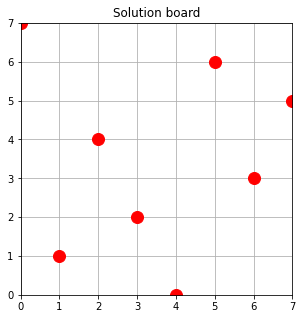

In [6]:
def main():
    MAXGENERATIONS = 200
    try:
        # Initialize a generation of a particular size
        gen = Generation(size = 20)    
        #kick off evolution process and get result of evolution
        gen.evolve(crosspoint = 4,mutationrate = 0.1,maxgenerations = MAXGENERATIONS)
        assert gen.genpopulation.fitnessscore == 0, "Unable to get a solution within {} generations".format(MAXGENERATIONS)
        print("Solution found in generation {}: {}".format(gen.generation, gen.fittestparent1))
        gen.displayfittestparent()
    except AssertionError as e:
        print ("!!!! Evolution Failed !!!!!!!")
        print(e)
    except Exception as e:
        print ("!!!! Evolution Failed !!!!!!!")
        print(e)
        #raise e

if __name__ == '__main__':
    main()